In [4]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random
import json
from collections import defaultdict, Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:

import torch

In [23]:
import chardet

def detect_encoding(filename):
    with open(filename, 'rb') as f:
        raw_data = f.read(10000)  # 读取前10000字节用于检测
        result = chardet.detect(raw_data)
    return result['encoding']

file_encoding = detect_encoding(filename)
print(f"检测到的文件编码: {file_encoding}")

检测到的文件编码: ISO-8859-1


In [19]:
# Define the file name
filename = 'Sentences_75Agree.txt'  # Specify the target file

def load_finphrase(filename):
    ''' 
    Clean and process the FinancialPhraseBank data
    Input:
        - filename: The name of the file to load
    Output:
        - DataFrame: The loaded and cleaned FinancialPhraseBank data
    '''
    try:
        # Read the file
        df = pd.read_csv(filename,
                         sep='@',  # Assume the file is delimited by '@'
                         engine='python',  # Use the Python engine for parsing
                         header=None,  # No header in the file
                         names=['sentence', 'label'],  # Define column names
                         encoding='latin1')  # Set file encoding
        print('Total number of records in the file:', df.shape[0])
        
        # Remove duplicate rows
        df.drop_duplicates(inplace=True)
        print('Total number of records after dropping duplicates:', df.shape[0])
        
        # Check for missing values in the 'label' column
        print('Missing labels:', df['label'].isnull().sum())
        
        # Reset the index
        df.reset_index(inplace=True, drop=True)
        
        return df
    except FileNotFoundError:
        print(f"File not found: {filename}")
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")

# Call the function to load the data
df_finphrase = load_finphrase(filename)

# Display the results
if df_finphrase is not None:
    print(df_finphrase.head())

Total number of records in the file: 3453
Total number of records after dropping duplicates: 3448
Missing labels: 0
                                            sentence     label
0  According to Gran , the company has no plans t...   neutral
1  With the new production plant the company woul...  positive
2  For the last quarter of 2010 , Componenta 's n...  positive
3  In the third quarter of 2010 , net sales incre...  positive
4  Operating profit rose to EUR 13.1 mn from EUR ...  positive


In [24]:
df_finphrase

,sentence,label
0,"According to Gran , the company has no plans t...",neutral
1,With the new production plant the company woul...,positive
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,"In the third quarter of 2010 , net sales incre...",positive
4,Operating profit rose to EUR 13.1 mn from EUR ...,positive
...,...,...
3443,Operating result for the 12-month period decre...,negative
3444,HELSINKI Thomson Financial - Shares in Cargote...,negative
3445,LONDON MarketWatch -- Share prices ended lower...,negative
3446,Operating profit fell to EUR 35.4 mn from EUR ...,negative


In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load data (ensure data cleaning steps have been performed)
# df_finphrase = load_finphrase(filename)

# Inspect data samples
print("Original data samples:")
print(df_finphrase.head(2))

# Label Encoding (Convert text labels to numerical values)
le = LabelEncoder()
df_finphrase['label_encoded'] = le.fit_transform(df_finphrase['label'])

# Split dataset into train/test sets with stratified sampling
X = df_finphrase['sentence']  # Text features
y = df_finphrase['label_encoded']  # Encoded labels

# Perform stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,  # 20% for test set (adjustable)
    stratify=y,     # Preserve class distribution
    random_state=42 # Reproducible results
)

# Display split statistics
print("\nTrain/Test Set Statistics:")
print(f"Training set samples: {len(X_train)} ({len(X_train)/len(X):.1%})")
print(f"Test set samples: {len(X_test)} ({len(X_test)/len(X):.1%})")

# Show class distribution
print("\nTraining set label distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print("Test set label distribution:")
print(pd.Series(y_test).value_counts().sort_index())

# Display label encoding mapping
print("\nLabel encoding mapping:")
for i, label in enumerate(le.classes_):
    print(f"{i} -> {label}")

Original data samples:
                                            sentence     label  label_encoded
0  According to Gran , the company has no plans t...   neutral              1
1  With the new production plant the company woul...  positive              2

Train/Test Set Statistics:
Training set samples: 2758 (80.0%)
Test set samples: 690 (20.0%)

Training set label distribution:
label_encoded
0     336
1    1713
2     709
Name: count, dtype: int64
Test set label distribution:
label_encoded
0     84
1    428
2    178
Name: count, dtype: int64

Label encoding mapping:
0 -> negative
1 -> neutral
2 -> positive


In [32]:
# check the distribution of the labels 
df_finphrase['label'].value_counts(normalize=True)

label
neutral     0.620940
positive    0.257251
negative    0.121810
Name: proportion, dtype: float64

<Axes: xlabel='label'>

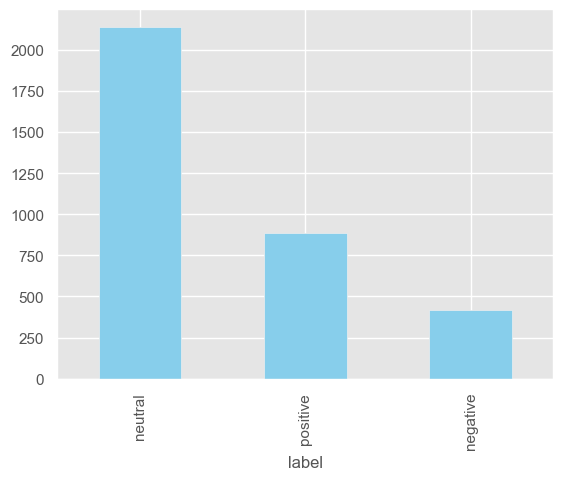

In [35]:
# view the distribution of the labels
df_finphrase['label'].value_counts().plot(kind='bar', color='skyblue')

<Axes: ylabel='Frequency'>

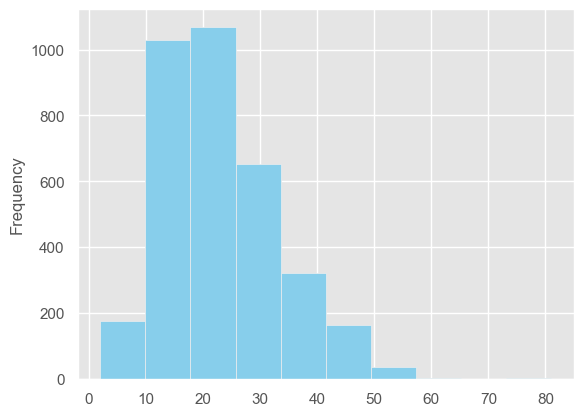

In [41]:
# view the word chang du of the sentences,use matplotlib
df_finphrase['sentence'].apply(lambda x: len(x.split())).plot(kind='hist', color='skyblue')
